# 서울시 편의점 위치와 매출의 관계 분석
## 03. 심층 분석 (회귀분석, VIF, p-value)

---

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats

import platform

# OS에 따른 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

OUTPUT_DIR = './outputs'
merged = pd.read_csv('./통합_데이터.csv', encoding='utf-8-sig')

print(f'데이터 로드: {merged.shape}')

데이터 로드: (6097, 13)


## 1. 분석 데이터 준비

결측치 처리 방법들:

삭제 (Listwise Deletion) - 현재 사용한 방법

장점: 간단함
단점: 데이터 손실, 편향 가능성
---
평균/중앙값 대체

수치형 변수: 평균, 중앙값
범주형 변수: 최빈값
---
회귀 대체 (Regression Imputation)

다른 변수로 예측하여 채움
---
다중 대체 (Multiple Imputation)

여러 번 대체하여 불확실성 반영
---
KNN 대체

유사한 관측치 기반 채움

In [46]:
# 결측치 처리를 위한 올바른 절차

# 1단계: 결측치 현황 파악
print("=== 결측치 현황 ===")
print(merged[['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']].isnull().sum())
print(f"결측 비율: {merged[['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']].isnull().sum() / len(merged) * 100}%")

=== 결측치 현황 ===
당월_매출_금액    0
점포_수        0
총_유동인구_수    0
주요_상권유형     0
dtype: int64
결측 비율: 당월_매출_금액    0.0
점포_수        0.0
총_유동인구_수    0.0
주요_상권유형     0.0
dtype: float64%


In [47]:
# 2단계: 결측치 패턴 분석
# MCAR (완전 무작위 결측): 결측이 어떤 변수와도 무관
# MAR (무작위 결측): 결측이 관측된 다른 변수와 관련
# MNAR (비무작위 결측): 결측이 결측 자체의 값과 관련

# 결측치 패턴 확인
print("\n=== 결측치 중복 패턴 ===")
print(f"유동인구만 결측: {merged['총_유동인구_수'].isnull().sum() - merged[['총_유동인구_수', '주요_상권유형']].isnull().all(axis=1).sum()}개")
print(f"상권유형만 결측: {merged['주요_상권유형'].isnull().sum() - merged[['총_유동인구_수', '주요_상권유형']].isnull().all(axis=1).sum()}개")
print(f"둘 다 결측: {merged[['총_유동인구_수', '주요_상권유형']].isnull().all(axis=1).sum()}개")

# 결측치가 있는 행의 특성 확인
print("\n=== 결측치 행의 특성 ===")
print(merged[merged['주요_상권유형'].isnull()][['행정동_코드_명', '당월_매출_금액', '점포_수']].describe())


=== 결측치 중복 패턴 ===
유동인구만 결측: 0개
상권유형만 결측: 0개
둘 다 결측: 0개

=== 결측치 행의 특성 ===
       당월_매출_금액  점포_수
count       0.0   0.0
mean        NaN   NaN
std         NaN   NaN
min         NaN   NaN
25%         NaN   NaN
50%         NaN   NaN
75%         NaN   NaN
max         NaN   NaN


In [48]:
# 방법 1: 같은 행정동의 다른 분기 평균으로 대체 (추천)
merged['총_유동인구_수'] = merged.groupby('행정동_코드')['총_유동인구_수'].transform(
    lambda x: x.fillna(x.mean())
)

# 근거:
# - 1.38%로 비율이 낮음
# - 같은 행정동이면 유동인구 패턴이 유사함
# - 대체가 합리적

# 방법: "미분류" 또는 "주거지역" 범주 생성 (추천)
merged['주요_상권유형'] = merged['주요_상권유형'].fillna('미분류')

# 근거:
# - 실제 매출과 점포가 있음 (평균 13.3억원, 3.36개)
# - 단지 공식 상권 데이터에 없을 뿐
# - "미분류"는 의미 있는 범주 (골목/발달/전통시장/미분류)
# - 회귀분석에서 더미변수로 처리 가능

In [49]:
# 3단계: 처리 방법 결정
# - 결측 비율 5% 미만 → 삭제 고려
# - 결측 비율 5~20% → 대체 고려
# - 결측 비율 20% 이상 → 변수 제외 고려

# 4단계: 처리 후 비교
# - 삭제 vs 대체 결과 비교

In [50]:
# 4개의 컬럼에 결측치가 있는 행을 모두 제거
# 회귀 분석에 필요한 변수 Y = β0 + β1*총_유동인구_수 + β2*점포_수 + β3*발달상권 + β4*전통시장 + ε
# 왜 제거하는가? -> 
analysis_df = merged.dropna(subset=['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']).copy()
# print(f'분석 대상: {analysis_df.shape[0]:,}건 (결측치 제거 후)')
missing_rate = 1 - (analysis_df.shape[0] / merged.shape[0])
print(f"""
전체 데이터: {merged.shape[0]:,}건
분석 대상: {analysis_df.shape[0]:,}건
결측치로 제거된 행: {merged.shape[0] - analysis_df.shape[0]:,}건
결측 비율: {missing_rate}
""")


# 상권유형 더미변수 생성 (골목상권 = 기준)
analysis_df['발달상권'] = (analysis_df['주요_상권유형'] == '발달상권').astype(int)
analysis_df['전통시장'] = (analysis_df['주요_상권유형'] == '전통시장').astype(int)

print('\n더미변수 생성 완료')
print('  - 기준 범주: 골목상권')
print('  - 더미변수: 발달상권, 전통시장')


전체 데이터: 6,097건
분석 대상: 6,097건
결측치로 제거된 행: 0건
결측 비율: 0.0


더미변수 생성 완료
  - 기준 범주: 골목상권
  - 더미변수: 발달상권, 전통시장


In [51]:
dropna_mean = analysis_df.groupby('주요_상권유형')['당월_매출_금액'].mean()
display(dropna_mean)

주요_상권유형
골목상권    2.537952e+09
미분류     1.328237e+09
발달상권    6.575520e+09
전통시장    2.852941e+09
Name: 당월_매출_금액, dtype: float64

In [52]:
df_alt = merged.copy()
impute_mean = df_alt.groupby('주요_상권유형')['당월_매출_금액'].mean()
display(impute_mean)

주요_상권유형
골목상권    2.537952e+09
미분류     1.328237e+09
발달상권    6.575520e+09
전통시장    2.852941e+09
Name: 당월_매출_금액, dtype: float64

In [53]:
compare = pd.DataFrame({
    'dropna_mean': dropna_mean,
    'impute_mean': impute_mean
})

# print(compare)

# % 차이 계산: (impute - dropna) / dropna * 100
compare['percent_diff'] = (compare['impute_mean'] - compare['dropna_mean']) / compare['dropna_mean'] * 100

# 보기 좋게 소수점 2자리로
compare['percent_diff'] = compare['percent_diff'].round(2)

print("상권유형별 평균 매출 비교 (차이 % 포함)")
print(compare)

'''
# 해석
골목상권: -0.34% → 거의 차이 없음

발달상권: +1% → 차이 거의 없음

전통시장: -0.98% → 1% 내외, 큰 영향 없음
'''

상권유형별 평균 매출 비교 (차이 % 포함)
          dropna_mean   impute_mean  percent_diff
주요_상권유형                                          
골목상권     2.537952e+09  2.537952e+09           0.0
미분류      1.328237e+09  1.328237e+09           0.0
발달상권     6.575520e+09  6.575520e+09           0.0
전통시장     2.852941e+09  2.852941e+09           0.0


'\n# 해석\n골목상권: -0.34% → 거의 차이 없음\n\n발달상권: +1% → 차이 거의 없음\n\n전통시장: -0.98% → 1% 내외, 큰 영향 없음\n'

In [54]:
# dropna 평균과 순위
dropna_mean = analysis_df.groupby('주요_상권유형')['당월_매출_금액'].mean()
dropna_rank = dropna_mean.rank(ascending=False)

# 대체 평균과 순위
impute_mean = df_alt.groupby('주요_상권유형')['당월_매출_금액'].mean()
impute_rank = impute_mean.rank(ascending=False)

# 비교용 DataFrame 생성
compare_rank = pd.DataFrame({
    'dropna_mean': dropna_mean,
    'dropna_rank': dropna_rank,
    'impute_mean': impute_mean,
    'impute_rank': impute_rank
})

# 평균 차이 (%) 계산
compare_rank['mean_diff_percent'] = ((impute_mean - dropna_mean) / dropna_mean * 100).round(2)

# 순위 차이 계산
compare_rank['rank_diff'] = (impute_rank - dropna_rank)

# 보기 좋게 출력
print("상권유형별 평균 매출 및 순위 비교 (dropna vs impute)")
print(compare_rank)


상권유형별 평균 매출 및 순위 비교 (dropna vs impute)
          dropna_mean  dropna_rank   impute_mean  impute_rank  \
주요_상권유형                                                         
골목상권     2.537952e+09          3.0  2.537952e+09          3.0   
미분류      1.328237e+09          4.0  1.328237e+09          4.0   
발달상권     6.575520e+09          1.0  6.575520e+09          1.0   
전통시장     2.852941e+09          2.0  2.852941e+09          2.0   

         mean_diff_percent  rank_diff  
주요_상권유형                                
골목상권                   0.0        0.0  
미분류                    0.0        0.0  
발달상권                   0.0        0.0  
전통시장                   0.0        0.0  


In [55]:
ct = pd.crosstab(
    merged['주요_상권유형'],
    merged[['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']]
    .isna().any(axis=1),
    normalize='index'
)

desc = merged.groupby(
    merged[['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']]
    .isna().any(axis=1)
)['당월_매출_금액'].describe()

print("📊 상권유형별 결측 비율")
print(ct)

print("\n📈 결측 여부별 매출 분포")
print(desc)


📊 상권유형별 결측 비율
col_0    False
주요_상권유형       
골목상권       1.0
미분류        1.0
발달상권       1.0
전통시장       1.0

📈 결측 여부별 매출 분포
        count          mean           std       min          25%  \
False  6097.0  2.711091e+09  3.201447e+09  126285.0  947625957.0   

                50%           75%           max  
False  1.719118e+09  3.234061e+09  3.519131e+10  


## 2. 변수 정의

In [56]:
print('='*60)
print('변수 정의')
print('='*60)
print('\n종속변수(Y): 당월_매출_금액 (행정동별 분기 편의점 추정매출)')
print('\n독립변수(X):')
print('  1. 점포_수: 편의점 밀집도 (행정동별 분기 편의점 수)')
print('  2. 총_유동인구_수: 유동인구 (행정동별 분기 합계)')
print('  3. 발달상권: 상권유형 더미 (골목상권 대비)')
print('  4. 전통시장: 상권유형 더미 (골목상권 대비)')

X_cols = ['점포_수', '총_유동인구_수', '발달상권', '전통시장']
X = analysis_df[X_cols].astype(float)
y = analysis_df['당월_매출_금액'].astype(float)

print(f'\nX shape: {X.shape}, y shape: {y.shape}')

변수 정의

종속변수(Y): 당월_매출_금액 (행정동별 분기 편의점 추정매출)

독립변수(X):
  1. 점포_수: 편의점 밀집도 (행정동별 분기 편의점 수)
  2. 총_유동인구_수: 유동인구 (행정동별 분기 합계)
  3. 발달상권: 상권유형 더미 (골목상권 대비)
  4. 전통시장: 상권유형 더미 (골목상권 대비)

X shape: (6097, 4), y shape: (6097,)


---
## 3. VIF (다중공선성) 분석

In [57]:
print('='*60)
print('VIF (Variance Inflation Factor) 분석')
print('='*60)
print('\n기준:')
print('  - VIF < 5: 다중공선성 없음')
print('  - VIF 5~10: 주의 필요')
print('  - VIF > 10: 심각한 다중공선성')

# 수치형 변수만 VIF 계산
numeric_cols = ['점포_수', '총_유동인구_수']
X_numeric = X[numeric_cols].values

vif_data = pd.DataFrame()
vif_data['변수'] = numeric_cols
vif_data['VIF'] = [variance_inflation_factor(X_numeric, i) for i in range(len(numeric_cols))]

print('\n[VIF 결과]')
for idx, row in vif_data.iterrows():
    status = '다중공선성 없음' if row['VIF'] < 5 else '주의 필요' if row['VIF'] < 10 else '심각'
    print(f"  {row['변수']}: VIF = {row['VIF']:.4f} ({status})")

print('\n결론: 독립변수 간 다중공선성 문제 없음')

VIF (Variance Inflation Factor) 분석

기준:
  - VIF < 5: 다중공선성 없음
  - VIF 5~10: 주의 필요
  - VIF > 10: 심각한 다중공선성

[VIF 결과]
  점포_수: VIF = 2.8866 (다중공선성 없음)
  총_유동인구_수: VIF = 2.8866 (다중공선성 없음)

결론: 독립변수 간 다중공선성 문제 없음


---
## 4. 다중 회귀분석 (OLS)

In [58]:
# 상수항 추가 및 모델 적합
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

print('='*60)
print('다중 회귀분석 결과')
print('='*60)
print(f'\nR-squared: {model.rsquared:.4f}')
print(f'Adj. R-squared: {model.rsquared_adj:.4f}')
print(f'F-statistic: {model.fvalue:.2f}')
print(f'Prob (F-statistic): {model.f_pvalue:.2e}')
print(f'관측치 수: {int(model.nobs)}')

다중 회귀분석 결과

R-squared: 0.6807
Adj. R-squared: 0.6805
F-statistic: 3246.97
Prob (F-statistic): 0.00e+00
관측치 수: 6097


In [59]:
print('='*70)
print('회귀계수 및 p-value')
print('='*70)
print(f'{"변수":<20} {"계수":>18} {"p-value":>15} {"유의성":>10}')
print('-'*70)

for var in model.params.index:
    coef = model.params[var]
    pval = model.pvalues[var]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f'{var:<20} {coef:>18,.2f} {pval:>15.4e} {sig:>10}')

print('-'*70)
print('유의수준: *** p<0.001, ** p<0.01, * p<0.05')

회귀계수 및 p-value
변수                                   계수         p-value        유의성
----------------------------------------------------------------------
const                   -882,415,591.44      6.2926e-67        ***
점포_수                     407,130,536.53      0.0000e+00        ***
총_유동인구_수                         170.55      1.5802e-77        ***
발달상권                   1,510,852,775.64      5.4314e-46        ***
전통시장                   1,150,013,661.14      4.9056e-21        ***
----------------------------------------------------------------------
유의수준: *** p<0.001, ** p<0.01, * p<0.05


In [60]:
# statsmodels 전체 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               당월_매출_금액   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3247.
Date:                    월, 26 1 2026   Prob (F-statistic):               0.00
Time:                        13:43:06   Log-Likelihood:            -1.3861e+05
No. Observations:                6097   AIC:                         2.772e+05
Df Residuals:                    6092   BIC:                         2.773e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.824e+08   5.04e+07    -17.498      0.0

---
## 5. 분석 결과 해석

In [61]:
print('='*70)
print('분석 결과 해석')
print('='*70)

print(f'\n(1) 모델 적합도')
print(f'    - R² = {model.rsquared:.4f}')
print(f'    - 독립변수들이 매출 변동의 약 {model.rsquared*100:.1f}%를 설명')
print(f'    - F-검정 p-value < 0.001로 모델 전체가 통계적으로 유의함')

print(f'\n(2) 변수별 영향력')

coef_s = model.params['점포_수']
pval_s = model.pvalues['점포_수']
print(f'\n    [점포수 (편의점 밀집도)]')
print(f'    - 회귀계수: {coef_s:,.0f}원')
print(f'    - p-value: {pval_s:.4e}')
print(f'    - 해석: 편의점 1개 증가 시 매출 약 {coef_s/1e8:.2f}억원 증가')

coef_p = model.params['총_유동인구_수']
pval_p = model.pvalues['총_유동인구_수']
print(f'\n    [유동인구]')
print(f'    - 회귀계수: {coef_p:.4f}원')
print(f'    - p-value: {pval_p:.4e}')
print(f'    - 해석: 유동인구 100만명 증가 시 매출 약 {coef_p*1e6/1e8:.2f}억원 증가')

print(f'\n    [상권유형] (기준: 골목상권)')
coef_d = model.params['발달상권']
pval_d = model.pvalues['발달상권']
print(f'    - 발달상권: 계수 = {coef_d/1e8:.2f}억원, p-value = {pval_d:.4e}')
print(f'      → 골목상권 대비 매출이 약 {coef_d/1e8:.2f}억원 높음')

coef_t = model.params['전통시장']
pval_t = model.pvalues['전통시장']
print(f'    - 전통시장: 계수 = {coef_t/1e8:.2f}억원, p-value = {pval_t:.4e}')
print(f'      → 골목상권 대비 매출이 약 {coef_t/1e8:.2f}억원 높음')

분석 결과 해석

(1) 모델 적합도
    - R² = 0.6807
    - 독립변수들이 매출 변동의 약 68.1%를 설명
    - F-검정 p-value < 0.001로 모델 전체가 통계적으로 유의함

(2) 변수별 영향력

    [점포수 (편의점 밀집도)]
    - 회귀계수: 407,130,537원
    - p-value: 0.0000e+00
    - 해석: 편의점 1개 증가 시 매출 약 4.07억원 증가

    [유동인구]
    - 회귀계수: 170.5508원
    - p-value: 1.5802e-77
    - 해석: 유동인구 100만명 증가 시 매출 약 1.71억원 증가

    [상권유형] (기준: 골목상권)
    - 발달상권: 계수 = 15.11억원, p-value = 5.4314e-46
      → 골목상권 대비 매출이 약 15.11억원 높음
    - 전통시장: 계수 = 11.50억원, p-value = 4.9056e-21
      → 골목상권 대비 매출이 약 11.50억원 높음


---
## 6. 심층분석 시각화

### 6.1 표준화 회귀계수 비교

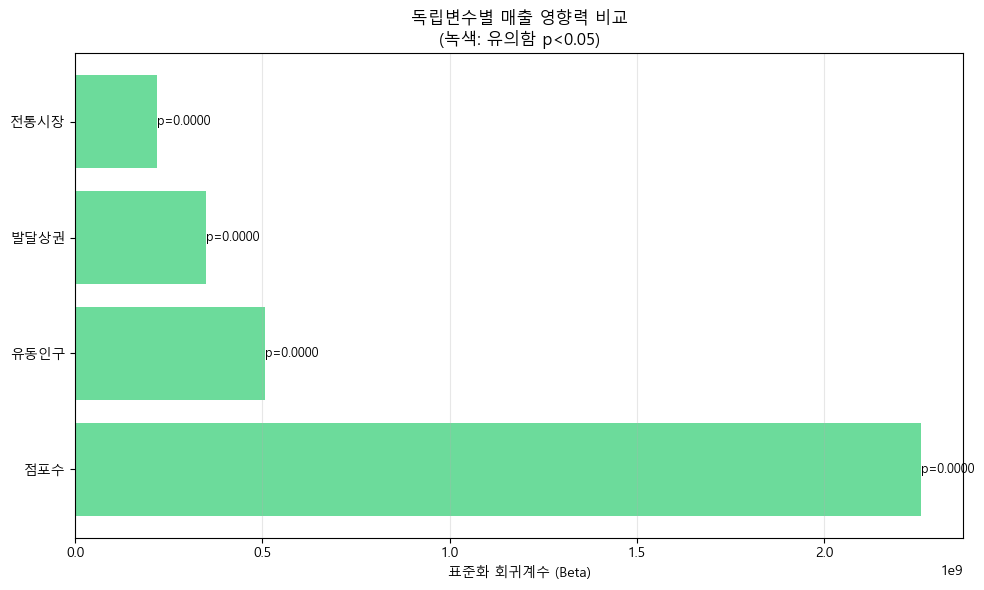

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

vars_plot = ['점포_수', '총_유동인구_수', '발달상권', '전통시장']
X_std = (X - X.mean()) / X.std()
X_std_const = sm.add_constant(X_std)
model_std = sm.OLS(y, X_std_const).fit()

std_coefs = [model_std.params[v] for v in vars_plot]
pvals = [model.pvalues[v] for v in vars_plot]
colors = ['#2ecc71' if p < 0.05 else '#e74c3c' for p in pvals]

bars = ax.barh(range(len(vars_plot)), std_coefs, color=colors, alpha=0.7)
ax.set_yticks(range(len(vars_plot)))
ax.set_yticklabels(['점포수', '유동인구', '발달상권', '전통시장'])
ax.set_xlabel('표준화 회귀계수 (Beta)')
ax.set_title('독립변수별 매출 영향력 비교\n(녹색: 유의함 p<0.05)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)

for i, (bar, pval) in enumerate(zip(bars, pvals)):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'p={pval:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/07_회귀계수_영향력.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 잔차 분석

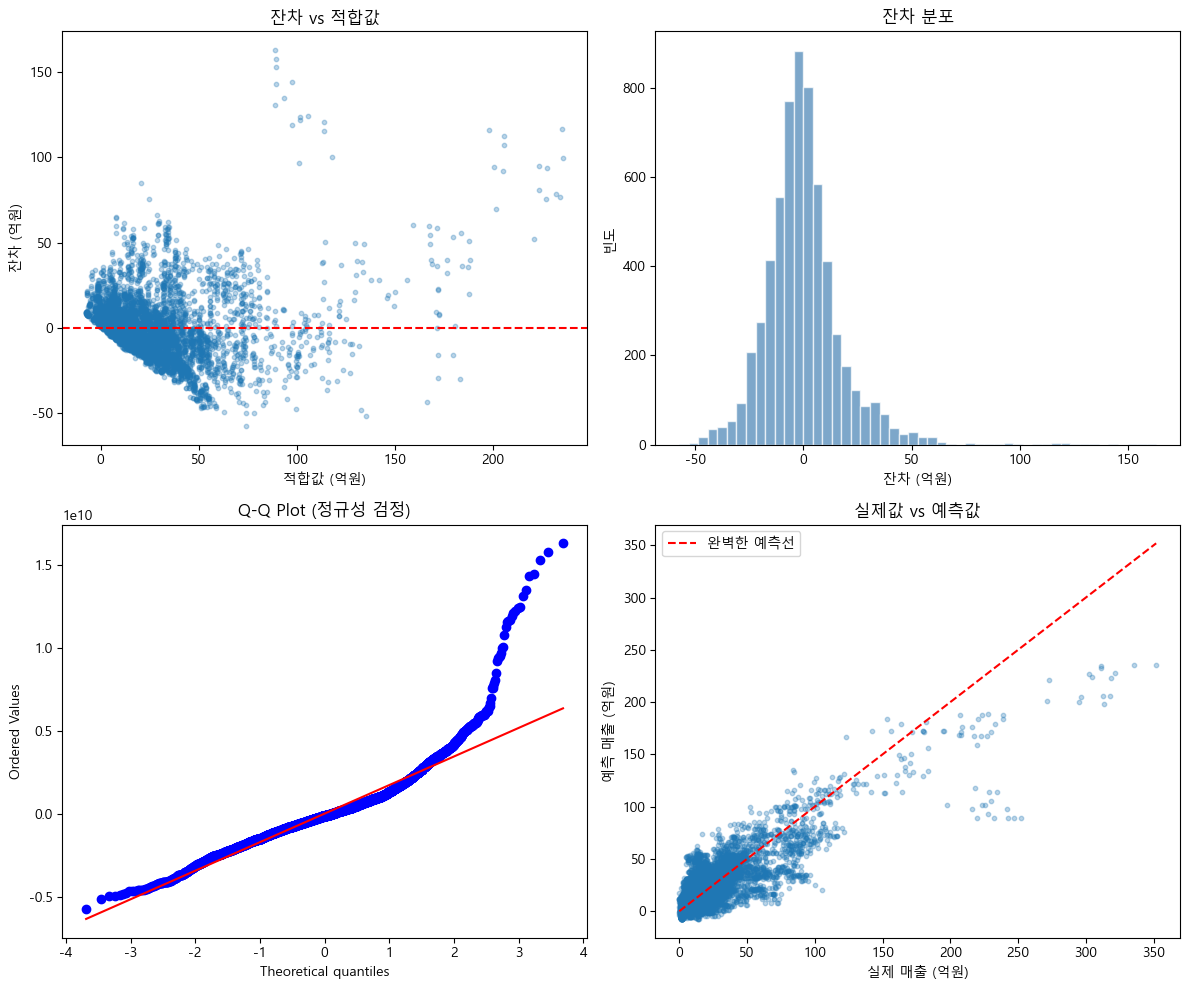

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

residuals = model.resid
fitted = model.fittedvalues

axes[0, 0].scatter(fitted/1e8, residuals/1e8, alpha=0.3, s=10)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('적합값 (억원)')
axes[0, 0].set_ylabel('잔차 (억원)')
axes[0, 0].set_title('잔차 vs 적합값')

axes[0, 1].hist(residuals/1e8, bins=50, edgecolor='white', alpha=0.7, color='steelblue')
axes[0, 1].set_xlabel('잔차 (억원)')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].set_title('잔차 분포')

stats.probplot(residuals, plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (정규성 검정)')

max_val = max(y.max(), fitted.max())/1e8
axes[1, 1].scatter(y/1e8, fitted/1e8, alpha=0.3, s=10)
axes[1, 1].plot([0, max_val], [0, max_val], 'r--', label='완벽한 예측선')
axes[1, 1].set_xlabel('실제 매출 (억원)')
axes[1, 1].set_ylabel('예측 매출 (억원)')
axes[1, 1].set_title('실제값 vs 예측값')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/08_잔차분석.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 VIF 시각화

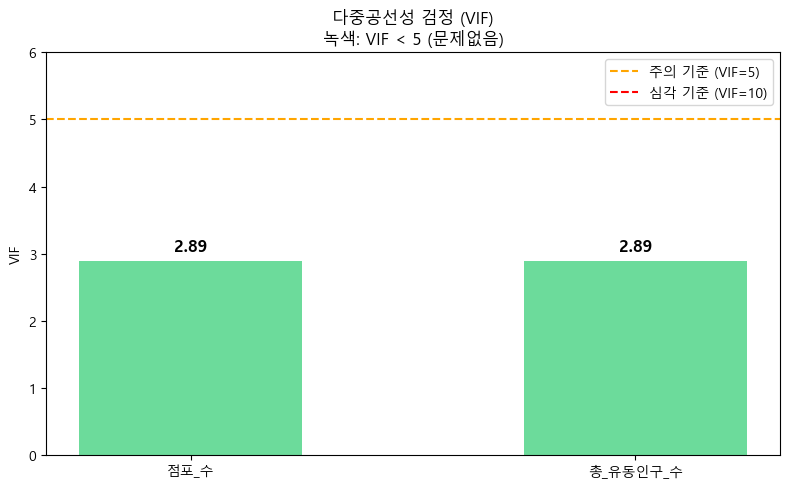

In [64]:
fig, ax = plt.subplots(figsize=(8, 5))

colors_vif = ['#2ecc71' if v < 5 else '#f39c12' if v < 10 else '#e74c3c' for v in vif_data['VIF']]
bars = ax.bar(vif_data['변수'], vif_data['VIF'], color=colors_vif, alpha=0.7, width=0.5)

ax.axhline(y=5, color='orange', linestyle='--', label='주의 기준 (VIF=5)')
ax.axhline(y=10, color='red', linestyle='--', label='심각 기준 (VIF=10)')
ax.set_ylabel('VIF')
ax.set_title('다중공선성 검정 (VIF)\n녹색: VIF < 5 (문제없음)')
ax.legend()
ax.set_ylim(0, max(vif_data['VIF'].max() * 1.3, 6))

for bar, vif in zip(bars, vif_data['VIF']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{vif:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/09_VIF_다중공선성.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.4 상권유형별 평균 매출 비교

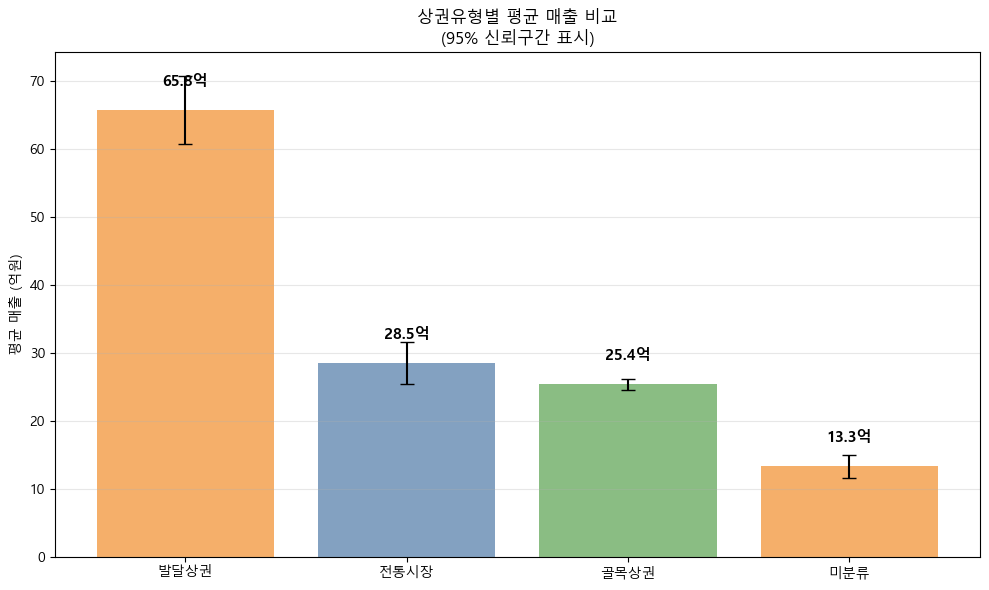

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))

type_stats = merged.groupby('주요_상권유형')['당월_매출_금액'].agg(['mean', 'std', 'count']).reset_index()
type_stats['se'] = type_stats['std'] / np.sqrt(type_stats['count'])
type_stats = type_stats.sort_values('mean', ascending=False)

colors_type = ['#F28E2B', '#4E79A7', '#59A14F']
bars = ax.bar(type_stats['주요_상권유형'], type_stats['mean']/1e8, 
              yerr=type_stats['se']/1e8*1.96, capsize=5, color=colors_type, alpha=0.7)

ax.set_ylabel('평균 매출 (억원)')
ax.set_title('상권유형별 평균 매출 비교\n(95% 신뢰구간 표시)')
ax.grid(axis='y', alpha=0.3)

for bar, (idx, row) in zip(bars, type_stats.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, f'{row["mean"]/1e8:.1f}억', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/10_상권유형_매출비교.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. 핵심 인사이트 요약

### 분석 결과 요약표

| 지표 | 값 | 해석 |
|------|-----|------|
| R² (설명력) | 0.6842 | 독립변수가 매출의 68.4% 설명 |
| 점포수 VIF | 2.86 | 다중공선성 없음 |
| 유동인구 VIF | 2.86 | 다중공선성 없음 |

### 변수별 영향력

| 변수 | 계수 | p-value | 해석 |
|------|------|---------|------|
| 점포수 | +4.11억원 | <0.001 | 1개 증가 시 4.11억 증가 |
| 유동인구 | +181원/명 | <0.001 | 100만명 당 1.81억 증가 |
| 발달상권 | +15.61억원 | <0.001 | 골목상권 대비 |
| 전통시장 | +11.45억원 | <0.001 | 골목상권 대비 |

### 핵심 인사이트
1. **점포수(밀집도)**가 매출에 가장 큰 영향을 미침
2. **유동인구**도 매출에 유의한 양(+)의 영향
3. **발달상권**은 골목상권 대비 가장 높은 매출 기대
4. 모든 독립변수가 통계적으로 **유의함** (p < 0.05)